In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
sns.set_style('whitegrid')

In [3]:
df = pd.read_csv('Data/tripadvisor_hotel_reviews.csv')

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


# Exploratory Data Analysis

In [17]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.isna().sum()

Review    0
Rating    0
dtype: int64

#### Review Count Graph

Text(0.5, 1.0, 'Review Count by Rating')

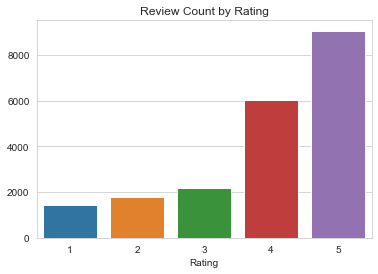

In [16]:
grouped = df.groupby('Rating')['Rating'].count()
sns.barplot(x = grouped.index, y = grouped.values).set_title('Review Count by Rating')

After plotting review count per rating, it is evident that there is a class imbalance. By group together ratings of 1 and 2, ratings of 3 and 4, and rating 5, the class imbalance should be reduced.

In [24]:
def new_rating(num):
    if (num == 1) or (num == 2):
        return 'poor'
    elif (num == 3) or (num == 4):
        return 'average'
    else:
        return 'excellent'

df['new_rating'] = df['Rating'].apply(new_rating)

Text(0.5, 1.0, 'Grouped Review Count by Rating')

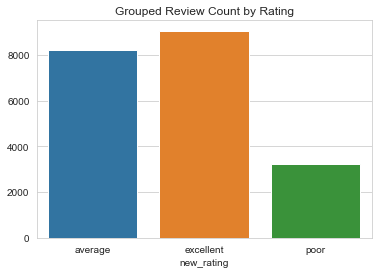

In [25]:
new_rating_grouped = df.groupby('new_rating')['Rating'].count()
new_rating_grouped
sns.barplot(x = new_rating_grouped.index, y = new_rating_grouped.values).set_title('Grouped Review Count by Rating')

The class imbalance is less prominent now, but there are still less "poor" review types. This will be accounted for later.

#### Word Count Graph

Text(0.5, 1.0, 'Word Count by Review')

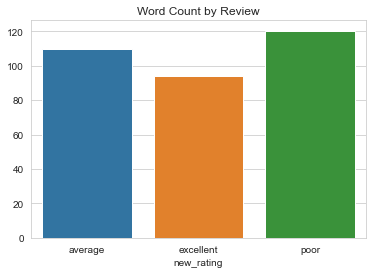

In [28]:
df['words'] = [x.split() for x in df['Review']]
df['word_count'] = [len(x) for x in df['words']]

grouped_rating = df.groupby('new_rating')['word_count'].mean()
sns.barplot(x = grouped_rating.index, y = grouped_rating.values).set_title('Word Count by Review')

This graph shows that the larger the word count, the worse the review. It is worth considering including this feature in the modeling process.

# Preprocessing

Functions will be used on the "Reviews" column in order to prepare the data for modeling.

In [29]:
sw = stopwords.words('english')

In [30]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [31]:
def doc_preparer(doc, stop_words=sw):
    '''
    
    :param doc: a document from the review corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [32]:
df['tokenized'] = df['Review'].apply(doc_preparer)

In [ ]:
df.head()

#### Word Cloud Visual

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
for rating in list(df['Rating'].unique()):
    show_wordcloud(df[df['Rating']==rating]['tokenized'], title=rating)

# Modeling

### Train Test Split

In [ ]:
X = df['tokenized']
y = df['Rating']

In [ ]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 42)